# Performance analysis

In [1]:
import numpy as np
import pathlib

import pathlib
import json
import numpy as np
import time
import seaborn as sns;
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import itertools
sns.set()


def bessel_correct(stddev):
    return stddev * np.sqrt(5./4.)

def confidence_interval_t(stddev):
    t_95 = 2.776
    return bessel_correct(stddev) * t_95
    

def flatten_metrics(metrics):
    flattened = {}
    task_metric_metric_name = [
        ("CoLA", "mcc", "Matthews correlation"),
        ("MNLI", "mnli_acc", "Accuracy"),
        ("MRPC", "acc", "Accuracy"),
        ("QNLI", "acc", "Accuracy"),
        ("QQP", "acc", "Accuracy"),
        ("RTE", "acc", "Accuracy"),
        ("SST-2", "acc", "Accuracy"),
        ("STS-B", "pearson", "Pearson correlation"),
        ("WNLI", "acc", "Accuracy")
    ]
    for task, metric, metric_name in task_metric_metric_name:
        flattened[task] = {
            "metric": metric_name,
            "mean": metrics[task][metric][0],
            "stdv": bessel_correct(metrics[task][metric][1]),
            "ci": confidence_interval_t(metrics[task][metric][1])
        }

    return flattened

def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

def plot_all_task_metrics(metrics, save_path):
    all_tasks = sorted(metrics[0][1].keys())
    experiment_metrics = [(name, flatten_metrics(metrics)) for name, metrics in metrics]
    experiment_names = [e_m[0] for e_m in experiment_metrics]

    metrics_data = [e_m[1] for e_m in experiment_metrics]
    x_pos = np.arange(len(experiment_names))
    
    fig, axs = plt.subplots(3, 3, figsize=(9,9))

    # Get a color map
    my_cmap = sns.color_palette("Paired")
    patterns = [ r"--" ,  r"||", r"\\" , r"\\||" , r"--", r"--||", r"//", r"//||"]

    for i, task in enumerate(all_tasks):
        means = [m[task]["mean"] for m in metrics_data]
        errors = [m[task]["stdv"] for m in metrics_data]
        row = i // 3
        col = i % 3
        axs[row, col].bar(x_pos, means, yerr=errors, align='center', color=my_cmap)#my_cmap(my_norm(range(len(x_pos)))))   
        axs[row, col].set_ylabel(metrics_data[0][task]["metric"])
        axs[row, col].set_title(f"{task}")
        axs[row, col].set_xticks([])
        
        bars = axs[row, col].patches
        
        for bar, hatch in zip(bars, patterns):  # loop over bars and hatches to set hatches in correct order
            bar.set_hatch(hatch)
    legend_elements = [Patch(facecolor=my_cmap[i], hatch=patterns[i], label=exp) for i, exp in enumerate(experiment_names)]
    l_col = 3
    legend = plt.legend(flip(legend_elements, l_col), flip(experiment_names, l_col), loc='best', ncol=l_col, bbox_to_anchor=(0.8, -0.1), labelspacing=1.5, handlelength=4)
    for patch in legend.get_patches():
        patch.set_height(10)
        patch.set_y(-1)
    plt.subplots_adjust(right=1.5)
    fig.tight_layout()
    plt.show()
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')

In [2]:
evaluation_dir = pathlib.Path("../evaluate_masked")
name_path = {
   
    "majority baseline": evaluation_dir / "freq_baseline" / "results.json",
    "full model": evaluation_dir / "original_without_any_mask" / "baseline" / "results.json",

    "good subnetwork (pruned)": evaluation_dir / "original_with_mlp_mask_head_mask_together" / "baseline" / "results.json",
    "good subnetwork (retrained)": evaluation_dir / "retrain_with_mlp_mask_head_mask_together" / "baseline" / "results.json",

    "bad subnetwork (sampled, pruned)": evaluation_dir / "original_with_mlp_mask_head_mask_together_bad" / "baseline" / "results.json",
    "bad subnetwork (sampled, retrained)": evaluation_dir / "retrain_with_mlp_mask_head_mask_together_bad" / "baseline" / "results.json",


    "bad subnetwork (invert, pruned)": evaluation_dir / "original_with_mlp_mask_head_mask_together_invert" / "baseline" / "results.json",
    "bad subnetwork (invert, retrained)": evaluation_dir / "retrain_with_mlp_mask_head_mask_together_invert" / "baseline" / "results.json",

}


analyzed_metrics = []
for name, path in name_path.items():
    with path.open() as f:
        metrics = json.load(f)
    analyzed_metrics.append((name, metrics))

/home/sai/miniconda3/envs/bertexp/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


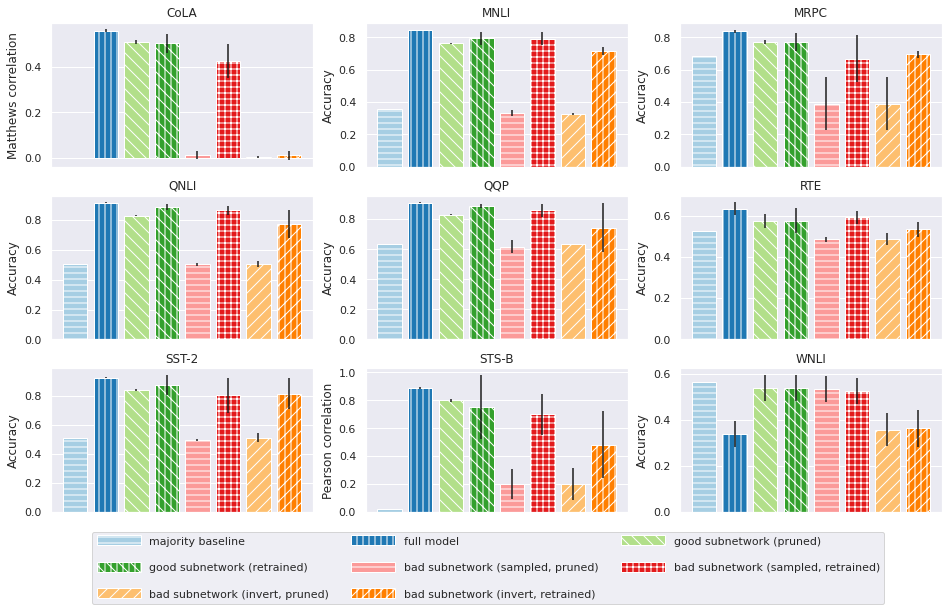

In [3]:
plot_all_task_metrics(analyzed_metrics, "evaluation/tasks_evaluation.pdf")

In [4]:
experiment_metrics = [(name, flatten_metrics(metrics)) for name, metrics in analyzed_metrics]
table_md = ""
experiments = [em[0] for em in experiment_metrics]
table_md += f"|Task|Metric|{'|'.join(experiments)}|\n"
table_md += f"|---|---|{'---|' * len(experiments)}\n"
tasks =  sorted(experiment_metrics[0][1].keys())
for task in tasks:
    mean_stds = [ f"{metrics[task]['mean']:.2f} ± {metrics[task]['stdv']:.2f}" for _, metrics in experiment_metrics]
    table_md += f"|{task}|{experiment_metrics[0][1][task]['metric']}|{'|'.join(mean_stds)}|\n"
    


In [5]:
print(table_md)

|Task|Metric|majority baseline|full model|good subnetwork (pruned)|good subnetwork (retrained)|bad subnetwork (sampled, pruned)|bad subnetwork (sampled, retrained)|bad subnetwork (invert, pruned)|bad subnetwork (invert, retrained)|
|---|---|---|---|---|---|---|---|---|---|
|CoLA|Matthews correlation|0.00 ± 0.00|0.56 ± 0.01|0.51 ± 0.01|0.50 ± 0.04|0.01 ± 0.02|0.43 ± 0.08|0.00 ± 0.00|0.01 ± 0.02|
|MNLI|Accuracy|0.35 ± 0.00|0.84 ± 0.00|0.76 ± 0.00|0.80 ± 0.04|0.33 ± 0.02|0.79 ± 0.04|0.33 ± 0.01|0.72 ± 0.03|
|MRPC|Accuracy|0.68 ± 0.00|0.84 ± 0.01|0.77 ± 0.01|0.77 ± 0.06|0.39 ± 0.16|0.67 ± 0.15|0.39 ± 0.16|0.70 ± 0.02|
|QNLI|Accuracy|0.51 ± 0.00|0.92 ± 0.00|0.83 ± 0.00|0.89 ± 0.02|0.50 ± 0.01|0.86 ± 0.03|0.50 ± 0.02|0.77 ± 0.09|
|QQP|Accuracy|0.63 ± 0.00|0.91 ± 0.00|0.83 ± 0.01|0.89 ± 0.01|0.62 ± 0.04|0.86 ± 0.05|0.63 ± 0.00|0.74 ± 0.16|
|RTE|Accuracy|0.53 ± 0.00|0.63 ± 0.03|0.57 ± 0.03|0.58 ± 0.06|0.48 ± 0.01|0.59 ± 0.03|0.49 ± 0.03|0.53 ± 0.04|
|SST-2|Accuracy|0.51 ± 0.00|0.93 ± 0.00|0.84